In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline
import os
import glob
from copy import deepcopy
import scipy.io as sio 
import sys
import os
import dlib

In [2]:
predictor_path = "shape_predictor_68_face_landmarks.dat/data"
# faces_folder_path = "./Eye_chimeraToPublish/Centre"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [3]:
def get_landmarks(im):
    """Single face landmark detector. return an nparray."""
    rects = detector(im, 1)
    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

# im = io.imread("./data/Eye_chimeraToPublish/0/eyes003019.jpg")
# landmarks = get_landmarks(im)

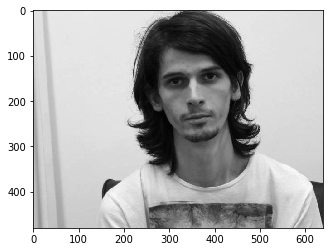

In [4]:
# Define the face and eye classifier
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascade_eye.xml')
img = mpimg.imread('./data/Eye_chimeraToPublish/0/eyes003019.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')
gray = gray.reshape((480,640,1))

[[121  53  49  49]
 [ 48  66  47  47]]


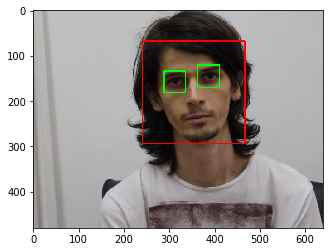

In [5]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
# plt.plot(121,53,'o')
plt.imshow(img)
# cv2.imshow('img',gray)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
print(eyes)

In [6]:
# load in eye_cinmera data, return image/label/matrix.
def load_eye_cinmera():
    X = []
    y = []
    Mat = []
    for i in range(7):
        faces_folder_path = "./data/Eye_chimeraToPublish/" + str(i)
        for f in glob.glob(os.path.join(faces_folder_path, "*.jpg")):
            f_name = os.path.basename(f)
            f_basename = f_name.split(".", 1)[0]
            # matrix file has the same name with the image file
            mat_name = f_basename + ".mat"
            mat_path = os.path.join(faces_folder_path, mat_name)
            img = io.imread(f)
            X.append(img)
            y.append(i)
            Mat.append(sio.loadmat(mat_path)['eyePoints'])
    return X, y, Mat
X, y, Mat = load_eye_cinmera()

(1135, 30, 50, 3)


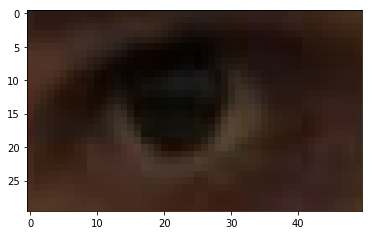

In [8]:
def extract_eye_by_mat(X, Mat, pad_scale=0.4, resize_width=50, resize_height=30):
    """given image and eye location datasets, return two eye images dataset."""
    X_left = []
    X_right = []
    for (img, mat) in zip(X, Mat):
        # the four egdes of left and right eyes
        left_left = mat[0][0]
        left_right = mat[1][0]
        left_top = mat[2][1]
        left_bottom = mat[3][1]
        right_left = mat[5][0]
        right_right = mat[6][0]
        right_top = mat[7][1]
        right_bottom = mat[8][1]
        # cut eyes images from the original one
        
        left_pad_width = int((left_right - left_left) * pad_scale)
        left_pad_height = int((left_bottom - left_top) * pad_scale)
        
        right_pad_width = int((right_right - right_left) * pad_scale)
        right_pad_height = int((right_bottom - right_top) * pad_scale)
        
        left_eye = img[left_top-left_pad_height : left_bottom+left_pad_height, left_left-left_pad_width : left_right+left_pad_width, :]
        right_eye = img[right_top-right_pad_height : right_bottom+right_pad_height, right_left-right_pad_width : right_right+right_pad_width, :]
        
        # reshape eye images to 50x42
        X_left.append(cv2.resize(left_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC))
        X_right.append(cv2.resize(right_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC))
        
    return np.array(X_left), np.array(X_right)
X_left, X_right = extract_eye_by_mat(X, Mat)
plt.imshow(X_left[1])
print(X_left.shape)


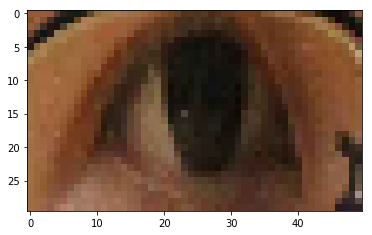

In [12]:
def extract_eyes_by_dlib(img, pad_scale=0.4, resize_width=50, resize_height=30):
    # get facial landmark matrix by dlib
    mat = get_landmarks(img)
    
    left_left = mat[36,0]
    left_right = mat[39,0]
    left_top = min(mat[37,1], mat[38,1])
    left_bottom = max(mat[40,1], mat[41,1])
    right_left = mat[42,0]
    right_right = mat[45,0]
    right_top = min(mat[43,1], mat[44,1])
    right_bottom = max(mat[46,1], mat[47,1])
    # left pad
    left_pad_width = int((left_right - left_left) * pad_scale)
    left_pad_height = int((left_bottom - left_top) * pad_scale)
    # right pad
    right_pad_width = int((right_right - right_left) * pad_scale)
    right_pad_height = int((right_bottom - right_top) * pad_scale)
    # left and right eye plus pads
    left_eye = img[left_top-left_pad_height : left_bottom+left_pad_height, left_left-left_pad_width : left_right+left_pad_width, :]
    right_eye = img[right_top-right_pad_height : right_bottom+right_pad_height, right_left-right_pad_width : right_right+right_pad_width, :]
    # resize
    left_eye = cv2.resize(left_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC)
    right_eye = cv2.resize(right_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC)
    return left_eye, right_eye

example_img = io.imread("./data/columbia_gaze_data_set/Columbia Gaze Data Set/0001/0001_2m_0P_0V_0H.jpg")
example_left, example_right = extract_eyes_by_dlib(example_img)
plt.imshow(example_left)

In [ ]:
# CURRENTLY ONLY CONSIDER LEFT EYE:

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# Shuffle X and y
X_left, y = shuffle(X_left, y)
print(X_left.shape)
# Split out test set
X_train, X_test, y_train, y_test = train_test_split(X_left, y, test_size=0.2, random_state=42)
print("X_train size: ", len(X_train))
print("X_train shape: ", X_train.shape)
print("X_test size: ", len(X_test))
# chang data type to floate32
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
    plt.title(str(y_train[i]))

print(X_train.shape)

In [ ]:
import tensorflow as tf
BATCH_SIZE = 128

# gray scale?


In [179]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(576, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 7), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(7))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [180]:
# Set placeholders for inputs
# Change this RGB to GRAY if gray scale is applied.
x_left_holder = tf.placeholder(tf.float32, (None, 30, 50, 3))
x_right_holder = tf.placeholder(tf.float32, (None, 30, 50, 3))
y_holder = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y_holder, 7)

In [181]:
rate = 0.001

logits = tf.reduce_mean(LeNet(x_left_holder), LeNet(x_right_holder))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [182]:
# """Training Pipeline"""
# rate = 0.001
# # logits: the score of a data point
# # LeNet 3x3; LeNet_0 5x5
# logits = LeNet(x)
# # the distance between score and the ground truth
# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# # average of all data points in training set
# # change the cross entropy to weighted version
# loss_operation = tf.reduce_mean(cross_entropy)
# # our goal is to min this average
# optimizer = tf.train.AdamOptimizer(learning_rate = rate)  # ADAM
# training_operation = optimizer.minimize(loss_operation)

In [183]:
"""Model Evaluation"""
# tf.argmax: Returns the index with the largest value across axis of a tensor.
# this step is to compare the prediction and the ground truth. E.g.: (1,1,0,1,1,0)--err:2/6
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    # tf.get_default_session(): Returns the default session for the current thread.
    # function evaluate() is called right after the training session.
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # accuracy for this particular batch
        accuracy = sess.run(accuracy_operation, feed_dict={x_holder: batch_x, y_holder: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [184]:
"""Input data"""
# Choose input dataset. 
# Options are original(X_train), normalized(X_train_nor), grayscale(X_train_gray).
X_train_input = X_train
X_valid_input = X_test
# X_test_input  = X_test_nor
y_valid = y_test
# print(X_train_input.shape, y_train.shape)
print(len(y_test))

227


In [185]:
"""Train model"""
# Model name: this name will be the save file name.
MODEL_NAME = "100epoch_dropout0.75"
EPOCHS = 100

### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
with tf.Session() as sess:
    # create a "logs" dir which will contain information for tensorboard
#     writer = tf.summary.FileWriter("logs", sess.graph)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # change different X_train input
        X_train_input, y_train = shuffle(X_train_input, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_input[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x_holder: batch_x, y_holder: batch_y})
        # change different X_valid input    
        validation_accuracy = evaluate(X_valid_input, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './trained_models/' + MODEL_NAME)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.366

EPOCH 2 ...
Validation Accuracy = 0.520

EPOCH 3 ...
Validation Accuracy = 0.604

EPOCH 4 ...
Validation Accuracy = 0.678

EPOCH 5 ...
Validation Accuracy = 0.744

EPOCH 6 ...
Validation Accuracy = 0.762

EPOCH 7 ...
Validation Accuracy = 0.824

EPOCH 8 ...
Validation Accuracy = 0.771

EPOCH 9 ...
Validation Accuracy = 0.811

EPOCH 10 ...
Validation Accuracy = 0.797

EPOCH 11 ...
Validation Accuracy = 0.828

EPOCH 12 ...
Validation Accuracy = 0.828

EPOCH 13 ...
Validation Accuracy = 0.815

EPOCH 14 ...
Validation Accuracy = 0.819

EPOCH 15 ...
Validation Accuracy = 0.846

EPOCH 16 ...
Validation Accuracy = 0.855

EPOCH 17 ...
Validation Accuracy = 0.846

EPOCH 18 ...
Validation Accuracy = 0.868

EPOCH 19 ...
Validation Accuracy = 0.863

EPOCH 20 ...
Validation Accuracy = 0.846

EPOCH 21 ...
Validation Accuracy = 0.859

EPOCH 22 ...
Validation Accuracy = 0.868

EPOCH 23 ...
Validation Accuracy = 0.872

EPOCH 24 ...
Validation Accura